In [1]:
from numpyro.examples.datasets import MNIST, load_dataset

train_init, train_fetch = load_dataset(MNIST)

In [2]:
num_train, train_idx = train_init()
X_tr, y_tr = train_fetch(0, train_idx)

In [3]:
X_tr = (X_tr > 0).astype("int8").reshape((X_tr.shape[0], -1))

In [26]:
import jax
import jax.numpy as jnp

import numpyro
from numpyro.contrib.hsgp.laplacian import eigenfunctions
from numpyro.contrib.hsgp.spectral_densities import (
    diag_spectral_density_squared_exponential,
)
import numpyro.distributions as dist


@jax.tree_util.register_pytree_node_class
class PPCA:
    def __init__(self, latent_dim: int):
        self.latent_dim = latent_dim

    def model(self, X: jnp.array):
        out_dim = X.shape[1]
        Z = numpyro.sample("Z", dist.Normal(0, 1).expand([X.shape[0], self.latent_dim]))

        beta = numpyro.sample(
            "beta", dist.Normal(0, 1), sample_shape=(self.latent_dim, out_dim)
        )
        f = Z @ beta
        numpyro.sample("obs", dist.BernoulliLogits(f), obs=X)

    def tree_flatten(self):
        children = ()  # arrays / dynamic values
        aux_data = self.latent_dim  # static values
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children, **aux_data)


@jax.tree_util.register_pytree_node_class
class HSGPLVM:
    def __init__(self, latent_dim: int, ell: float, m: int):
        self.latent_dim = latent_dim
        self.ell = ell
        self.m = m

    def model(self, X: jnp.array):
        out_dim = X.shape[1]
        Z = numpyro.sample("Z", dist.Normal(0, 1).expand([X.shape[0], self.latent_dim]))

        alpha = numpyro.sample("alpha", dist.LogNormal(0, 1))

        length_mean = numpyro.sample("length_mean", dist.Normal(0, 1))
        length_std = numpyro.sample("length_std", dist.LogNormal(0, 1))
        length = numpyro.sample("length", dist.LogNormal(length_mean, length_std), sample_shape=(out_dim, self.latent_dim))

        phi = eigenfunctions(x=Z, ell=self.ell, m=self.m)
        spd = jnp.sqrt(
            diag_spectral_density_squared_exponential(
                alpha=alpha, length=length, ell=self.ell, m=self.m, dim=self.latent_dim
            )
        )
        beta = numpyro.sample(
            "beta", dist.Normal(0, 1), sample_shape=(phi.shape[-1], out_dim)
        )

        # TODO add labels to loss
        f = phi @ (spd * beta)
        numpyro.sample("obs", dist.BernoulliLogits(f), obs=X)

    def tree_flatten(self):
        children = ()  # arrays / dynamic values
        aux_data = (self.latent_dim, self.ell, self.m)  # static values
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children, **aux_data)

In [27]:
from jax import random
from optax import linear_onecycle_schedule

from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.elbo import Trace_ELBO
from numpyro.infer.svi import SVI
from numpyro.optim import Adam


def fit_svi(
    seed: int,
    model: callable,
    guide: callable,
    num_steps: int = 1000,
    peak_lr: float = 0.01,
    progress_bar: bool = True,
    use_scheduler: bool = False,
    **model_kwargs,
):
    if use_scheduler:
        lr = linear_onecycle_schedule(num_steps, peak_lr)
    else:
        lr = peak_lr
    svi = SVI(model, guide, Adam(lr), Trace_ELBO())
    return svi.run(
        random.PRNGKey(seed), num_steps, progress_bar=progress_bar, **model_kwargs
    )

In [28]:
from numpyro.infer.initialization import init_to_median

m = HSGPLVM(2, 6.0, 10)
# 2, 6.0, 10 gives really sharp results already, even without vectorized lengthscales
    # num_steps = 1000
    # lr scheduled
    # elbo: 10782577
# with vectorized lengthscales...
    # num_steps = 1000
    # lr scheduled
    # elbo: 10734284
# with vectorized lengthscales and priors
    # num steps = 1000
    # lr unscheduled
    # elbo: 9892971 and still falling...
    # plot looks awesome...we're really close
# ...
    # num steps = 10_000
    # lr scheduled
    # ...
# m = 10 seems to perform even better
# elbo a good bit better on the gp version, runtime comparable
# m = PPCA(2)
guide = AutoNormal(m.model, init_loc_fn=init_to_median(num_samples=25))
svi_res = fit_svi(seed=0, model=m.model, guide=guide, X=X_tr, use_scheduler=True, num_steps=10_000)

100%|██████████| 1000/1000 [10:09<00:00,  1.64it/s, init loss: 33205782.0000, avg. loss [951-1000]: 9892971.9000]


In [29]:
from numpyro.infer import Predictive

post = Predictive(model=guide, params=svi_res.params, num_samples=1000)(
    random.PRNGKey(1)
)

In [32]:
post["length"].mean(axis=0).min()

Array(0.15095492, dtype=float32)

In [33]:
Z_post = post["Z"].mean(axis=0)

In [34]:
import pandas as pd

df = pd.DataFrame({"z0": Z_post[:, 0], "z1": Z_post[:, 1], "label": y_tr})
df["label"] = df["label"].astype("category")

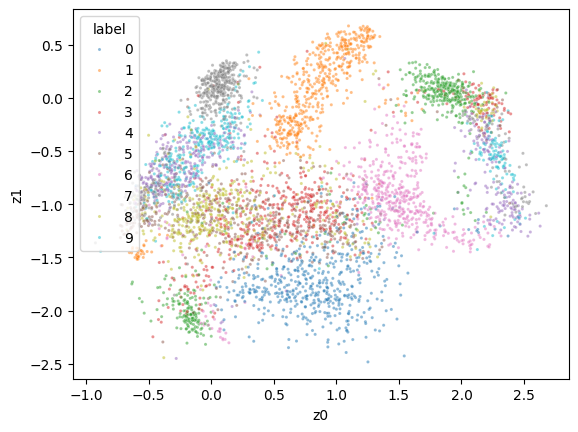

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns

n = 5_000
df_plot = df.sample(n)
sns.scatterplot(
    x=df_plot["z0"],
    y=df_plot["z1"],
    hue=df_plot["label"],
    palette="tab10",
    alpha=0.5,
    s=5,
)
# n = 1000
# c = y_tr
# x = Z_post[:, 0]
# y = Z_post[:, 1]
# plt.scatter(x[0:n], y[0:n], c=c[0:n], cmap='tab10')
# plt.legend([str(x) for x in jnp.unique(y_tr)])
plt.show()

In [11]:
df_plot["label"].unique()

[4, 2, 0, 3, 8, 7, 9, 5, 6, 1]
Categories (10, int8): [0, 1, 2, 3, ..., 6, 7, 8, 9]